In [1]:
from soundscape_IR.soundscape_viewer import audio_visualization
import matplotlib.pyplot as plt

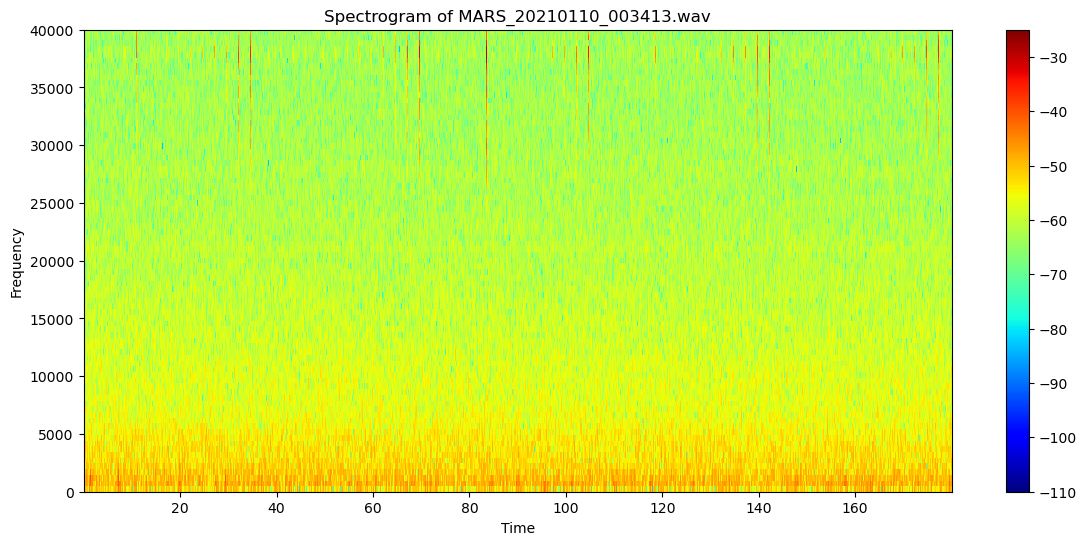

In [40]:
# constantly overflow memory
spec = audio_visualization(filename='MARS_20210110_003413.wav', duration_read=180, path='./data/california-pam/',
                          f_range=[0,40000], vmin=-110, vmax=-25)

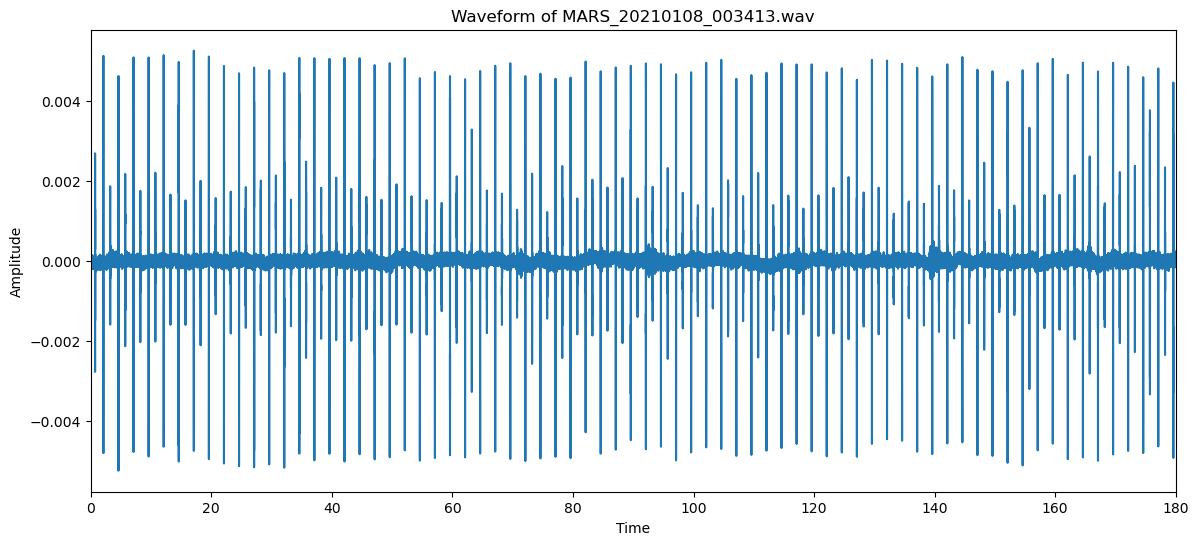

In [34]:
# constantly overflow memory
spec = audio_visualization(filename='MARS_20210108_003413.wav', duration_read=180, path='./data/california-pam/',
                          f_range=[0,40000], vmin=-110, vmax=-25, plot_type='Waveform')

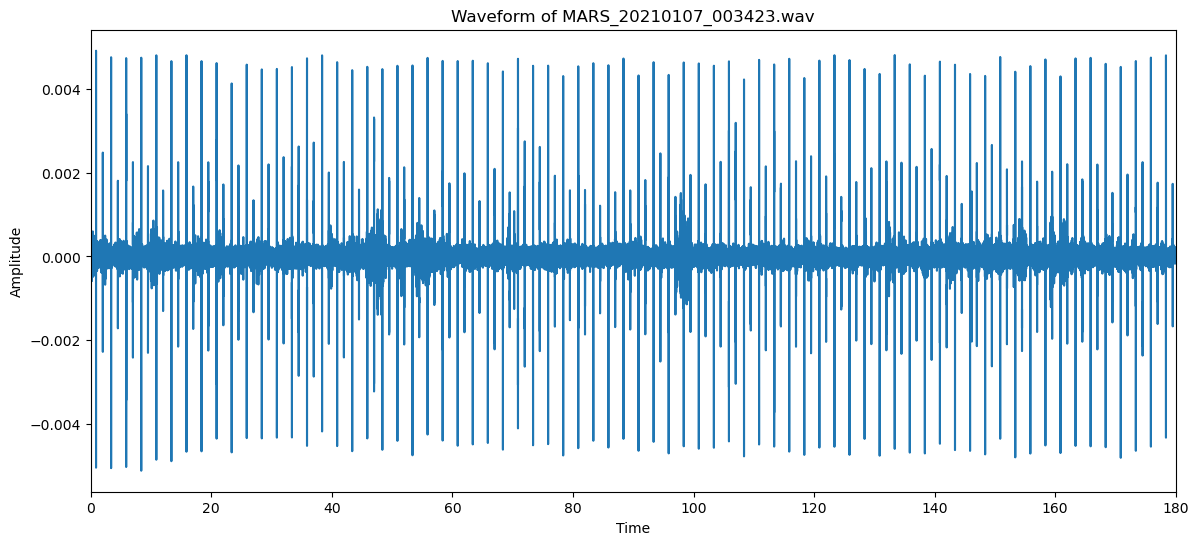

In [38]:
# constantly overflow memory
spec = audio_visualization(filename='MARS_20210107_003423.wav', duration_read=180, path='./data/california-pam/',
                          f_range=[0,40000], vmin=-110, vmax=-25, plot_type='Waveform')

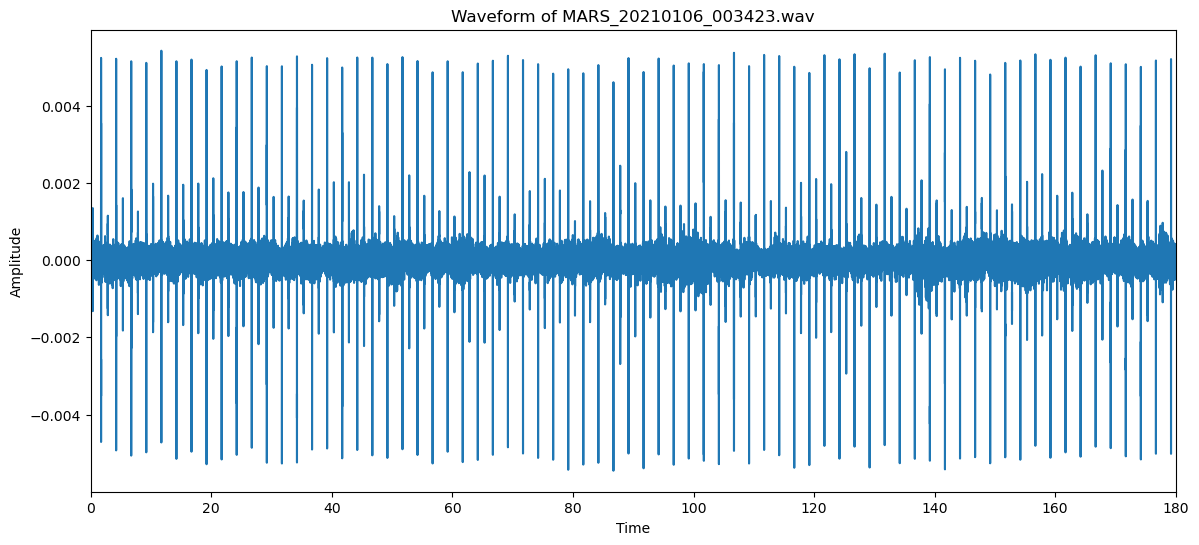

In [35]:
# constantly overflow memory
spec = audio_visualization(filename='MARS_20210106_003423.wav', duration_read=180, path='./data/california-pam/',
                          f_range=[0,40000], vmin=-110, vmax=-25, plot_type='Waveform')

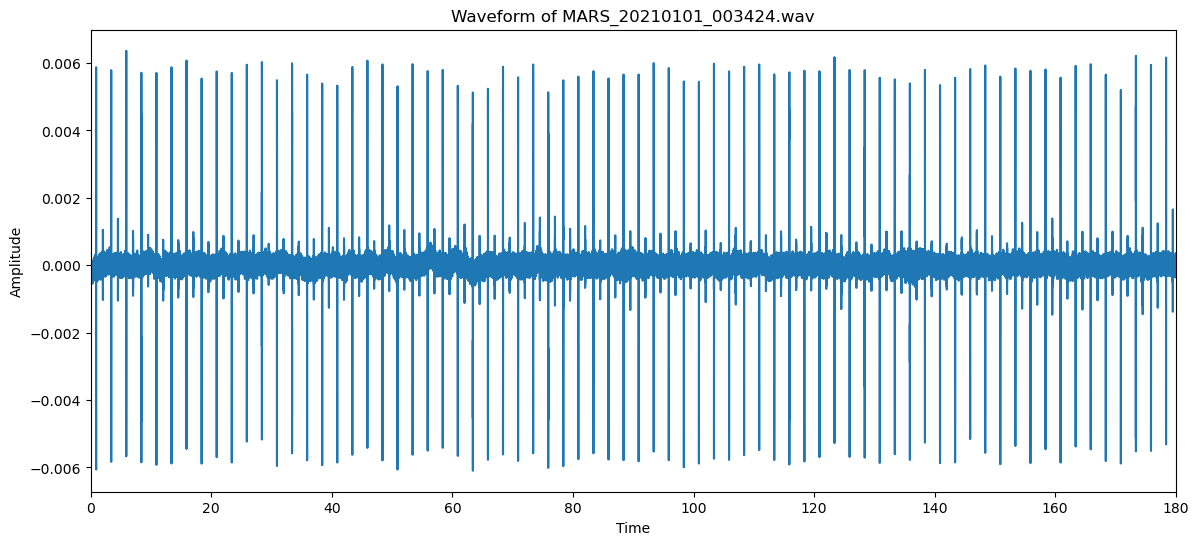

In [36]:
# constantly overflow memory
spec = audio_visualization(filename='MARS_20210101_003424.wav', duration_read=180, path='./data/california-pam/',
                          f_range=[0,40000], vmin=-110, vmax=-25, plot_type='Waveform')

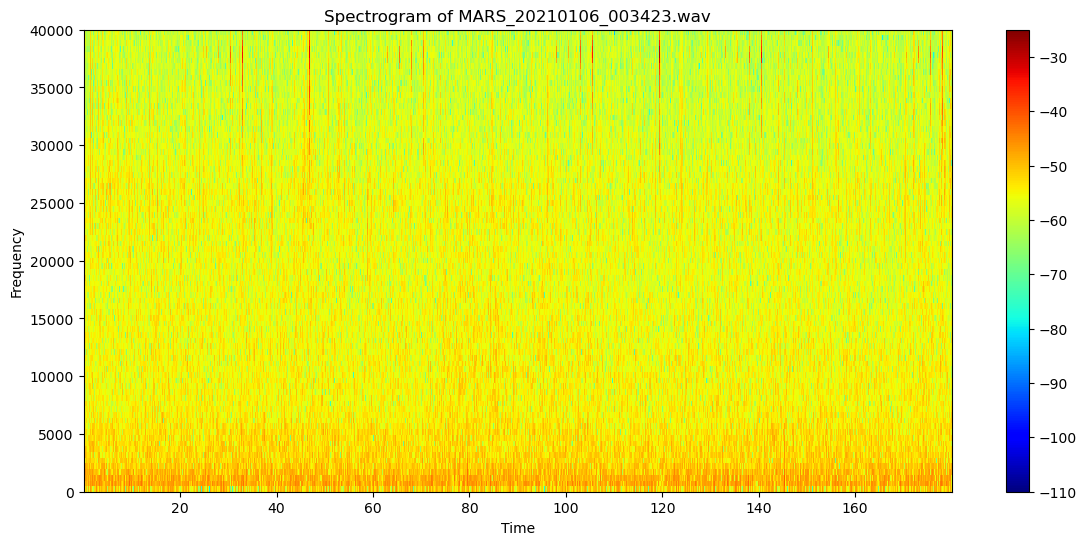

In [31]:
# constantly overflow memory
spec = audio_visualization(filename='MARS_20210106_003423.wav', duration_read=180, path='./data/california-pam/',
                          f_range=[0,40000], vmin=-110, vmax=-25)

In [8]:
import os
import wave

import pylab
def graph_spectrogram(wav_file):
    sound_info, frame_rate = get_wav_info(wav_file)
    pylab.figure(num=None, figsize=(19, 12))
    pylab.subplot(111)
    pylab.title('spectrogram of %r' % wav_file)
    pylab.specgram(sound_info, Fs=frame_rate)
    pylab.savefig('spectrogram.png')
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.fromstring(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate
